# Pet's Faces Dataset

|Студент| Плешков А.О. |
|:-----:|:-:|
|Группа|М8О-306Б-19|
|Вариант| 3 (нечётный) |
|Фреймворк| Tensorflow/Keras |

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [1]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2022-06-03 13:48:07--  https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-gzip]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M  10.4MB/s    in 2.2s    

2022-06-03 13:48:09 (10.4 MB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Flatten,InputLayer,Dense, Dropout, Convolution2D, MaxPool2D, Dropout, BatchNormalization

Переведем вычисления на GPU:

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Далее задаем размер батча и изображения:

In [4]:
batch_size = 32
img_length = 200
img_width = 200
data_dir = './petfaces'

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "training", seed = 123,
                                                         image_size = (img_length, img_width), batch_size = batch_size)

Found 3211 files belonging to 35 classes.
Using 2569 files for training.


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "validation", seed = 123,
                                                       image_size = (img_length, img_width), batch_size = batch_size)

Found 3211 files belonging to 35 classes.
Using 642 files for validation.


In [7]:
class_names = train_data.class_names
print(class_names)
print(len(class_names))

['cat_Abyssinian', 'cat_Bengal', 'cat_Birman', 'cat_Bombay', 'cat_British', 'cat_Egyptian', 'cat_Maine', 'cat_Persian', 'cat_Ragdoll', 'cat_Russian', 'cat_Siamese', 'cat_Sphynx', 'dog_american', 'dog_basset', 'dog_beagle', 'dog_boxer', 'dog_chihuahua', 'dog_english', 'dog_german', 'dog_great', 'dog_havanese', 'dog_japanese', 'dog_keeshond', 'dog_leonberger', 'dog_miniature', 'dog_newfoundland', 'dog_pomeranian', 'dog_pug', 'dog_saint', 'dog_samoyed', 'dog_scottish', 'dog_shiba', 'dog_staffordshire', 'dog_wheaten', 'dog_yorkshire']
35


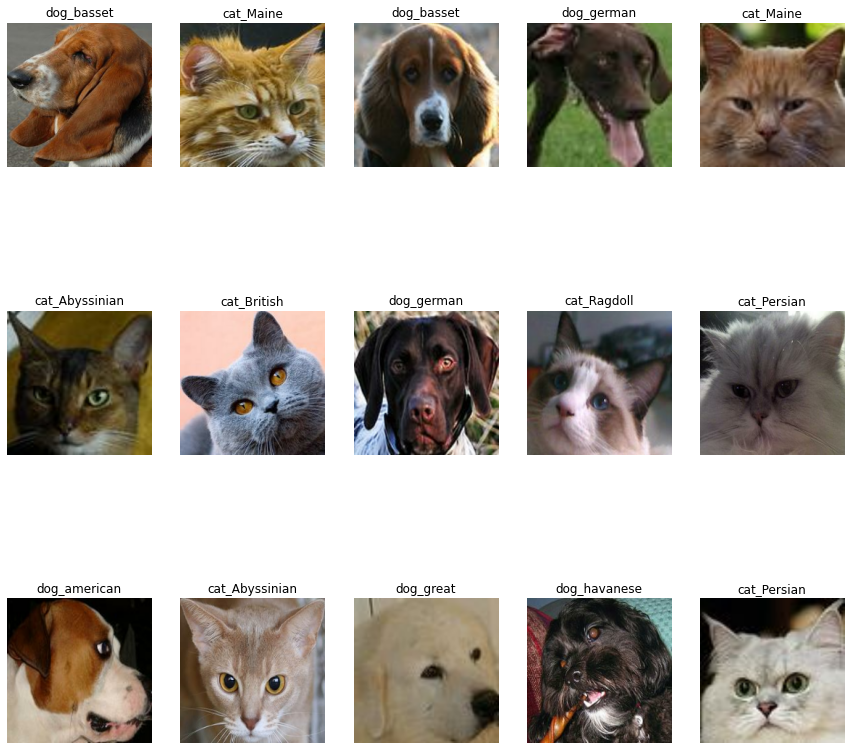

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 15))
for images, labels in train_data.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size = AUTOTUNE)

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape = (img_length, img_width, 3)),
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [13]:
epochs = 10
history = model.fit(train_data, validation_data = val_data, epochs = epochs)

Epoch 1/10
81/81 [==============================] - 13s 41ms/step - loss: 3.5689 - accuracy: 0.0506 - val_loss: 3.4099 - val_accuracy: 0.0654
Epoch 2/10
81/81 [==============================] - 2s 30ms/step - loss: 3.0597 - accuracy: 0.1724 - val_loss: 2.6114 - val_accuracy: 0.2523
Epoch 3/10
81/81 [==============================] - 2s 30ms/step - loss: 2.2273 - accuracy: 0.3686 - val_loss: 2.1668 - val_accuracy: 0.3505
Epoch 4/10
81/81 [==============================] - 2s 30ms/step - loss: 1.5451 - accuracy: 0.5609 - val_loss: 2.1591 - val_accuracy: 0.4159
Epoch 5/10
81/81 [==============================] - 2s 31ms/step - loss: 0.9563 - accuracy: 0.7131 - val_loss: 2.0649 - val_accuracy: 0.4642
Epoch 6/10
81/81 [==============================] - 2s 31ms/step - loss: 0.4756 - accuracy: 0.8622 - val_loss: 2.2715 - val_accuracy: 0.4907
Epoch 7/10
81/81 [==============================] - 2s 31ms/step - loss: 0.2069 - accuracy: 0.9385 - val_loss: 2.5480 - val_accuracy: 0.4564
Epoch 8/10
8

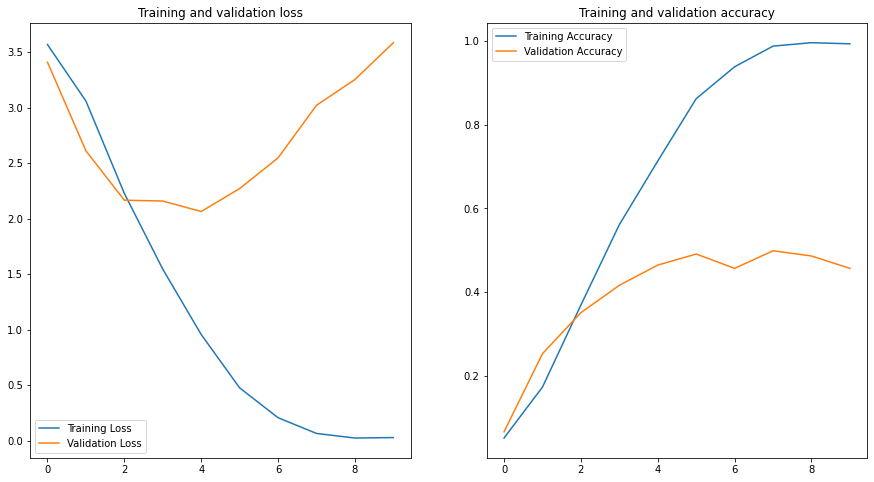

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(epochs)
plt.figure(figsize = (15, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'best')
plt.title('Training and validation loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'best')
plt.title('Training and validation accuracy')

plt.show()

Можно проследить признаки переобучения. Попробуем это исправить:

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape = (img_length, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [16]:
plt.figure(figsize = (15, 15))
for images, _ in train_data.take(1):
  for i in range(15):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [19]:
epochs = 40
history = model.fit(train_data, validation_data = val_data, epochs = epochs )

Epoch 1/40
81/81 [==============================] - 4s 39ms/step - loss: 3.5377 - accuracy: 0.0490 - val_loss: 3.5219 - val_accuracy: 0.0576
Epoch 2/40
81/81 [==============================] - 3s 35ms/step - loss: 3.3057 - accuracy: 0.0961 - val_loss: 3.1035 - val_accuracy: 0.1293
Epoch 3/40
81/81 [==============================] - 3s 36ms/step - loss: 3.0227 - accuracy: 0.1541 - val_loss: 2.7719 - val_accuracy: 0.2072
Epoch 4/40
81/81 [==============================] - 3s 36ms/step - loss: 2.7611 - accuracy: 0.2141 - val_loss: 2.4088 - val_accuracy: 0.2897
Epoch 5/40
81/81 [==============================] - 3s 36ms/step - loss: 2.4429 - accuracy: 0.2974 - val_loss: 2.1811 - val_accuracy: 0.3551
Epoch 6/40
81/81 [==============================] - 3s 35ms/step - loss: 2.2298 - accuracy: 0.3484 - val_loss: 2.0329 - val_accuracy: 0.4081
Epoch 7/40
81/81 [==============================] - 3s 35ms/step - loss: 2.0901 - accuracy: 0.3893 - val_loss: 1.7820 - val_accuracy: 0.4766
Epoch 8/40
81

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(epochs)
plt.figure(figsize = (15, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'best')
plt.title('Training and validation loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'best')
plt.title('Training and validation accuracy')

plt.show()

Довольно неплохие результаты.

Теперь проверим, как модель отличает собак от кошек:

In [21]:
pred = model.predict(val_data)

In [22]:
from scipy.special import softmax
pred = softmax(pred)

In [23]:
pred = np.where(pred.argmax(axis = 1) > 11, 1, 0)

In [24]:
pred

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,

In [25]:
labels = list(val_data.map(lambda x, y: y))
labels = list(map(lambda x: list(x.numpy()), labels))
res = []
for i in labels:
    res += i
labels = np.array(res)
labels = np.where(labels > 11, 1, 0)

In [26]:
labels

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [28]:
def scores(y_pred2, y):
    print("Accuracy sklearn model:", accuracy_score(y, y_pred2))
    figure = plt.figure(figsize = (20, 5))
    matr2 = confusion_matrix(y, y_pred2)
    ConfusionMatrixDisplay(matr2).plot()
    plt.show()

In [29]:
scores(labels, pred)

Accuracy sklearn model: 0.9657320872274143


<Figure size 1440x360 with 0 Axes>

Теперь посчитаем top-3 accuracy:

In [30]:
pred = model.predict(val_data)

In [31]:
pred = softmax(pred)

In [32]:
labels = list(val_data.map(lambda x, y: y))
labels = list(map(lambda x: list(x.numpy()), labels))
res = []
for i in labels:
  res += i
labels = np.array(res)

In [33]:
print(labels[:10])

[34 12 20 20  7 25 17 28 27 16]


In [34]:
from sklearn.metrics import top_k_accuracy_score
top_k_accuracy_score(labels, pred, k = 3)

0.8956386292834891

Построим confusion matrix для нашего классификатора:

In [35]:
y_true = labels
y_pred = pred.argmax(axis = 1)

In [36]:
print(y_true.shape, y_pred.shape, len(class_names))

(642,) (642,) 35


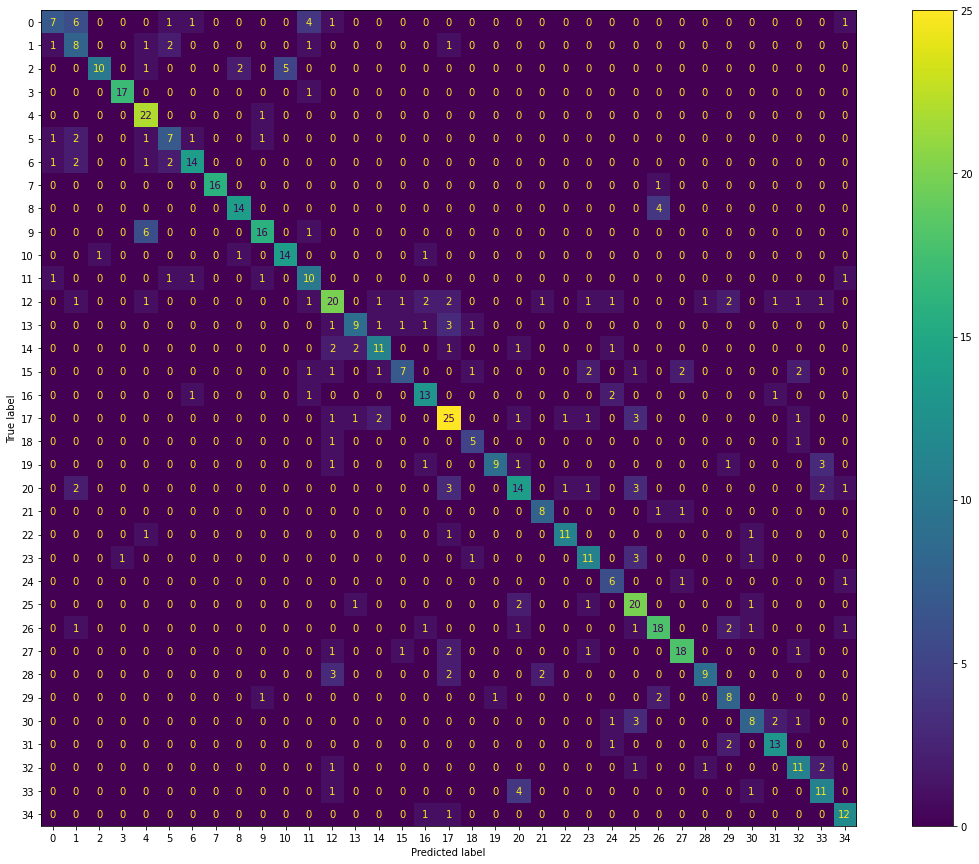

In [37]:
from sklearn.metrics import multilabel_confusion_matrix
from matplotlib.pyplot import figure
cf = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize = (20, 15))
ConfusionMatrixDisplay(cf).plot(ax = ax)
plt.show()

**Выводы:** Таким образом, в ходе выполнения данной лабораторной работы была построена модель для классификации изображений, относящихся к 35 различным классам. На этапе обучения были вычеслены training and validation loss,  training and validation accuracy. Также были построены графики для loss и accuracy в зависимости от эпохи обучения. Кроме того, был проведен анализ того, как полученная модель может различать кошек и собак. Была построена confution matrix и посчитано top-3 accuracy.